In [1]:
import pandas as pd
import numpy as np 
from scipy import stats
import statistics
pd.set_option('display.max_rows', 100)

# reading data from the files
df_users = pd.read_csv('users.csv') 
df_orders = pd.read_csv('orders.csv') 
df_balance = pd.read_csv('balance.csv') 

In [2]:
df_users.head()

,user_id,country_code,registration_time,traffic_source
0,25795,VN,2020-02-18 18:00:00,Organic
1,10861,Other,2020-06-23 08:00:00,Referral
2,48160,Other,2020-10-03 11:00:00,Referral
3,21287,ZA,2020-02-10 03:00:00,Google
4,16269,Other,2020-02-03 10:00:00,Google


In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1000 non-null   int64 
 1   country_code       1000 non-null   object
 2   registration_time  1000 non-null   object
 3   traffic_source     1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [4]:
df_orders.head()

,user_id,symbol,open_time,close_time,profit_usd
0,11643,XAUUSD,2020-11-27 03:00:00,2020-11-30 20:00:00,-120.14
1,11643,USDCHF,2020-09-17 03:00:00,2020-09-21 09:00:00,122.20
2,11643,BTCUSD,2020-08-13 14:00:00,2020-08-17 02:00:00,93.29
3,33581,EURUSD,2020-06-23 13:00:00,2020-06-24 00:00:00,95.20
4,11643,AUDCAD,2020-12-30 14:00:00,2020-12-30 14:00:00,75.47


In [5]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117461 entries, 0 to 117460
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     117461 non-null  int64  
 1   symbol      117461 non-null  object 
 2   open_time   117461 non-null  object 
 3   close_time  117461 non-null  object 
 4   profit_usd  117461 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.5+ MB


In [6]:
df_balance.head()

,user_id,operation_time,operation_type,operation_amount_usd
0,23678,2020-11-17 20:00:00,deposit,576.88
1,23678,2020-11-18 06:00:00,deposit,1382.39
2,23678,2020-11-18 07:00:00,deposit,960.50
3,23678,2020-11-20 12:00:00,deposit,893.28
4,23678,2020-11-23 05:00:00,deposit,746.97


In [7]:
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6496 entries, 0 to 6495
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               6496 non-null   int64  
 1   operation_time        6496 non-null   object 
 2   operation_type        6496 non-null   object 
 3   operation_amount_usd  6496 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 203.1+ KB


In [8]:
# adding a new column is_pandemic and creating a new df
df_orders['open_date'] =  pd.to_datetime(df_orders['open_time'])
df_orders['open_date'] = df_orders['open_date'].dt.normalize()      
df_orders['close_date'] =  pd.to_datetime(df_orders['close_time'])
df_orders['close_date'] = df_orders['close_date'].dt.normalize()    
df_orders['is_pandemic'] = np.where(df_orders['close_date']<'2020-05-01', 'no', \
                                    np.where((df_orders['open_time']<'2020-05-01')&(df_orders['close_date']>='2020-05-01'), 'mix', 'yes'))
df_orders = df_orders[df_orders['is_pandemic'].isin(['yes', 'no'])]
df_daily = df_orders.groupby(['close_date', 'is_pandemic'], as_index=False).agg(sum_d=('profit_usd', 'sum'), 
                                                               mean_d=('profit_usd', 'mean'), 
                                                               std_d=('profit_usd', 'std'),  
                                                               count_d=('profit_usd', 'count'))
df_daily.head()

,close_date,is_pandemic,sum_d,mean_d,std_d,count_d
0,2020-01-13,no,-19.67,-1.035263,69.178564,19
1,2020-01-14,no,541.06,24.593636,116.254089,22
2,2020-01-15,no,397.83,20.938421,107.195211,19
3,2020-01-16,no,-296.47,-32.941111,117.283993,9
4,2020-01-17,no,38.17,2.936154,104.002502,13


# Part 2: The impact of COVID

# Part 2.1 Market volatility

<Axes: xlabel='close_date', ylabel='std_d'>

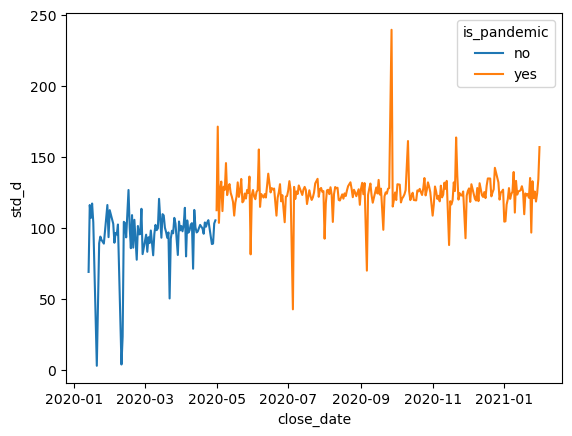

In [9]:
# std is used to compare 2 groups. Looks like before pandemic the market was less volatile.
import seaborn as sns
sns.lineplot(data=df_daily, x='close_date', y='std_d', hue='is_pandemic')

# Before the pandemic

C:\Users\arish\AppData\Local\Temp\ipykernel_23744\3952737894.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_daily_no['std_d'], hist=True, kde=True,


<Axes: xlabel='std_d', ylabel='Density'>

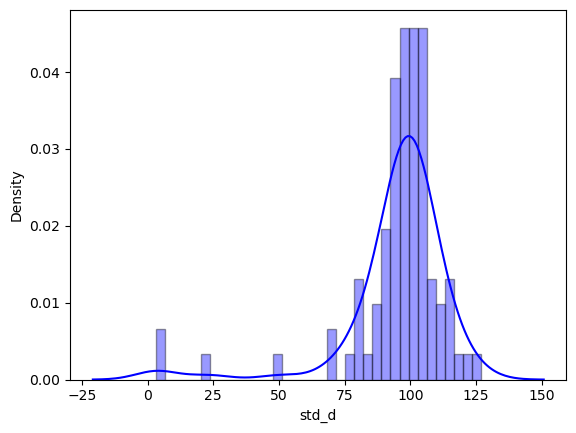

In [10]:
# in df_daily_no distribution is not normal due to anomalies
df_daily_no = df_daily[df_daily['is_pandemic']=='no'].copy()
sns.distplot(df_daily_no['std_d'], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'}) 

<Axes: >

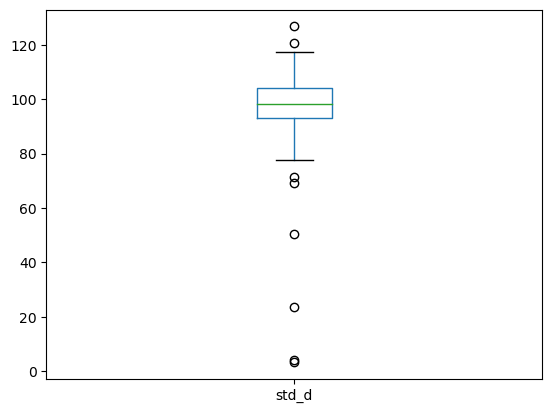

In [11]:
# let's use boxplot to remove anomalies
df_daily_no.boxplot(column =['std_d'], grid = False)

C:\Users\arish\AppData\Local\Temp\ipykernel_23744\862894363.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_daily_no['std_d'], hist=True, kde=True,


<Axes: xlabel='std_d', ylabel='Density'>

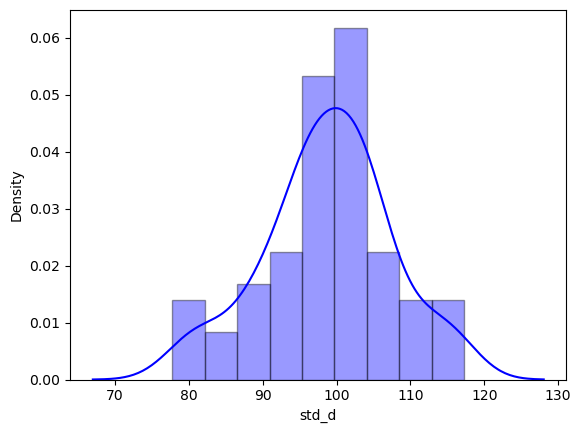

In [12]:
# now distribution looks normal
Q1 = df_daily_no['std_d'].quantile(0.25)
Q3 = df_daily_no['std_d'].quantile(0.75)
IQR = Q3 - Q1 

df_daily_no = df_daily_no[(df_daily_no['std_d'] >= Q1 - 1.5 * IQR) & (df_daily_no['std_d'] <= Q3 + 1.5 *IQR)]
sns.distplot(df_daily_no['std_d'], hist=True, kde=True, 
             bins=int(180/20), color = 'blue',
             hist_kws={'edgecolor':'black'})  

# During the pandemic

C:\Users\arish\AppData\Local\Temp\ipykernel_23744\843934096.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_daily_yes['std_d'], hist=True, kde=True,


<Axes: xlabel='std_d', ylabel='Density'>

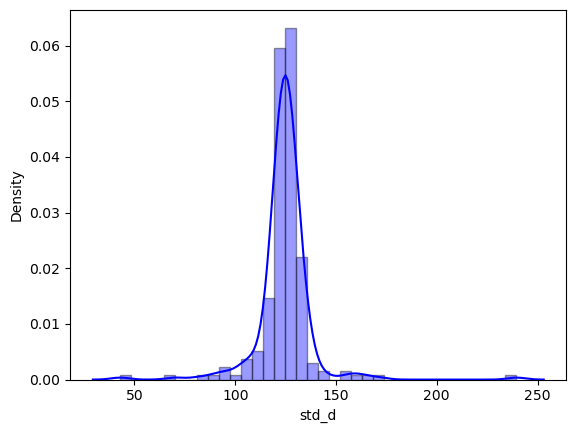

In [13]:
# in df_daily_yes distribution is not normal due to anomalies
df_daily_yes = df_daily[df_daily['is_pandemic']=='yes'].copy()
sns.distplot(df_daily_yes['std_d'], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})  

<Axes: >

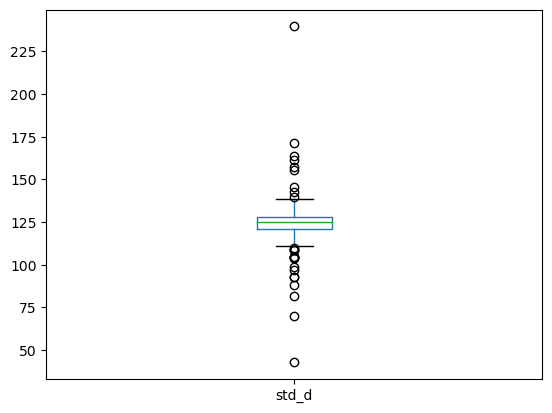

In [14]:
# let's use boxplot to remove anomalies
df_daily_yes.boxplot(column =['std_d'], grid = False)

C:\Users\arish\AppData\Local\Temp\ipykernel_23744\2136245294.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_daily_yes['std_d'], hist=True, kde=True,


<Axes: xlabel='std_d', ylabel='Density'>

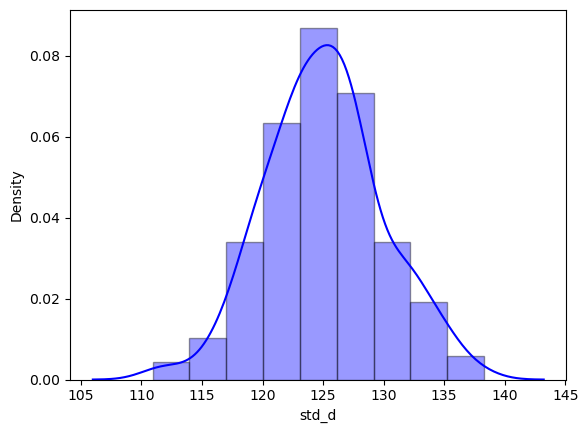

In [15]:
# now distribution looks normal
Q_1 = df_daily_yes['std_d'].quantile(0.25)
Q_3 = df_daily_yes['std_d'].quantile(0.75)
IQR_new = Q_3 - Q_1    #IQR is interquartile range. 

df_daily_yes = df_daily_yes[(df_daily_yes['std_d'] >= Q_1 - 1.5 * IQR_new) & (df_daily_yes['std_d'] <= Q_3 + 1.5 *IQR_new)]
sns.distplot(df_daily_yes['std_d'], hist=True, kde=True, 
             bins=int(180/20), color = 'blue',
             hist_kws={'edgecolor':'black'}) 

In [16]:
# let's compare means in 2 groups
result = (stats.ttest_ind(df_daily_no['std_d'], df_daily_yes['std_d']))
print('avg before the pandemic: {:.2f}'.format(statistics.mean(df_daily_no['std_d'])),';','avg during the pandemic: {:.2f}'.format(statistics.mean(df_daily_yes['std_d'])))
if result.pvalue > 0.05:
    print('Can not reject null hypothesis that the means are equal')
else:
    print('Reject the null hypothesis that the means are equal')

avg before the pandemic: 98.79 ; avg during the pandemic: 125.09
Reject the null hypothesis that the means are equal


In [17]:
# conclusion: after the pandemic the market has become more volatile compared to the period “before"

# Part 2.2 Profit

C:\Users\arish\AppData\Local\Temp\ipykernel_23744\119477594.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pandem_no['profit_usd'], hist=True, kde=True,


<Axes: xlabel='profit_usd', ylabel='Density'>

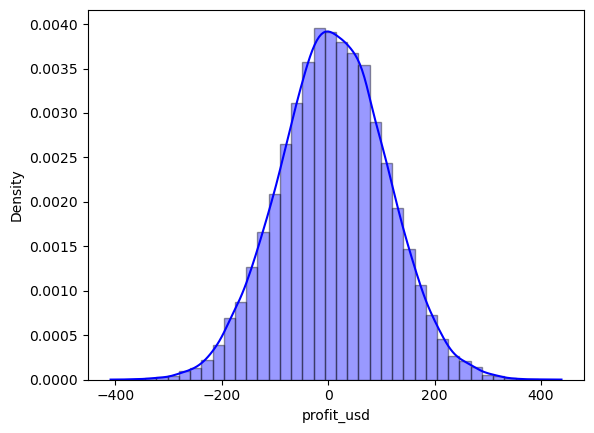

In [18]:
# let's take profit_usd is 2 groups
# distribution before the pandemic is normal 
df_pandem_no = df_orders[df_orders['is_pandemic']=='no'].copy()
sns.distplot(df_pandem_no['profit_usd'], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'}) 

C:\Users\arish\AppData\Local\Temp\ipykernel_23744\663465989.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pandem_yes['profit_usd'], hist=True, kde=True,


<Axes: xlabel='profit_usd', ylabel='Density'>

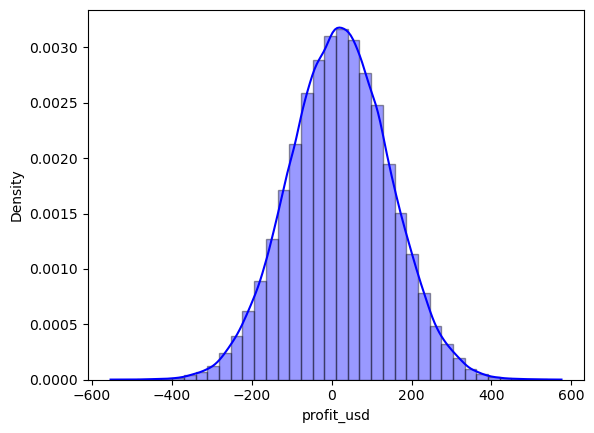

In [19]:
# distribution during the pandemic is normal 
df_pandem_yes = df_orders[df_orders['is_pandemic']=='yes'].copy()
sns.distplot(df_pandem_yes['profit_usd'], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'}) 

In [20]:
# # let's compare means in 2 groups
from scipy import stats
result = (stats.ttest_ind(df_pandem_no['profit_usd'], df_pandem_yes['profit_usd']))
print('avg profit before the pandemic: {:.2f}'.format(statistics.mean(df_pandem_no['profit_usd'])),';','avg profit during the pandemic: {:.2f}'.format(statistics.mean(df_pandem_yes['profit_usd'])))
if result.pvalue > 0.05:
    print('Can not reject null hypothesis that the means are equal')
else:
    print('Reject the null hypothesis that the means are equal')

avg profit before the pandemic: 9.66 ; avg profit during the pandemic: 19.65
Reject the null hypothesis that the means are equal


In [21]:
# conclusion: market volatility makes trading in any market, including Forex, MORE profitable 